In [1]:
# Source: https://github.com/mGalarnyk/Python_Tutorials/blob/master/Sklearn/PCA/PCA_Data_Visualization_Iris_Dataset_Blog.ipynb
# Source for FA: https://www.datacamp.com/community/tutorials/introduction-factor-analysis
import pandas as pd
import numpy as np
from sklearn.datasets import load_iris
from sklearn.decomposition import PCA, FactorAnalysis
from factor_analyzer import FactorAnalyzer
import matplotlib.pyplot as plt

url = "https://vincentarelbundock.github.io/Rdatasets/csv/psych/bfi.csv"

df = pd.read_csv(url)
df = df.drop(df.columns[0], axis=1)
df.head()
df.shape

(2800, 28)

In [2]:
df.drop(['gender', 'education', 'age'],axis=1,inplace=True)
df.dropna(inplace=True)

In [3]:
df.shape

(2436, 25)

In [4]:
# Adequacy test
from factor_analyzer.factor_analyzer import calculate_bartlett_sphericity
chi_square_value,p_value=calculate_bartlett_sphericity(df)
chi_square_value, p_value

(18170.966350869236, 0.0)

In this Bartlett ’s test, the p-value is 0. The test was statistically significant, indicating that the observed correlation matrix is not an identity matrix.
<br>
<br>
Kaiser-Meyer-Olkin (KMO) Test measures the suitability of data for factor analysis. It determines the adequacy for each observed variable and for the complete model. KMO estimates the <b>proportion</b> of variance among all the observed variable. 
<br> - KMO values range between 0 and 1.
<br> - Lower proportion id more suitable for factor analysis.
<br> - Value of KMO less than 0.6 is considered inadequate.

In [5]:
from factor_analyzer.factor_analyzer import calculate_kmo
kmo_all,kmo_model=calculate_kmo(df)
kmo_model

0.848539722194922

In [6]:
fa = FactorAnalyzer(n_factors=24)
fa.fit(df)
# Check Eigenvalues
ev, v = fa.get_eigenvalues()
len(ev)

25

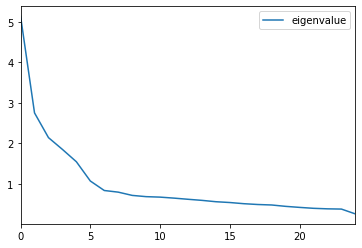

In [7]:
pd.DataFrame({'eigenvalue': ev}).plot()

# Using only 6 factors

In [8]:
fa = FactorAnalyzer(n_factors=6)
fa.fit(df)
fa.loadings_.shape

(25, 6)

## Examine the loading
Likely: each column is orthogonal and unit. But it is NOT.

In [9]:
for i in range(6):
    display(np.sum(fa.loadings_[0,:]*fa.loadings_[i,:]))
print()
for i in range(6):
    display(np.sum(fa.loadings_[:,0]*fa.loadings_[:,i]))

0.47330761716030245

-0.4091635464426591

-0.2776779698886085

-0.15663884542870948

-0.1393841408414177

0.10310631593479713

2.7727153535462077

0.21945708667212985

0.04143049402106608

-0.0636119792677965

0.10484610795162724

-0.08475499840345398

In [10]:
factor_variance = pd.DataFrame(fa.get_factor_variance())
factor_variance.columns = ['factor_' + str(x+1) for x in range(6)]
factor_variance.index = ['SS Loadings', 'Proportion', 'Cumlt var']
factor_variance

,factor_1,factor_2,factor_3,factor_4,factor_5,factor_6
SS Loadings,2.772715,2.569633,2.208900,1.485449,1.366273,0.995674
Proportion,0.110909,0.102785,0.088356,0.059418,0.054651,0.039827
Cumlt var,0.110909,0.213694,0.302050,0.361468,0.416119,0.455946


## Display the factor composition as heatmap
Note that I have square the weights of each loading

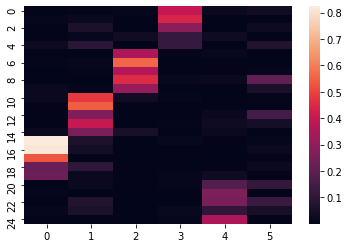

In [11]:
import seaborn as sns
sns.heatmap(fa.loadings_**2)

we can see clearly that some factors are highly correlated with one another

# Transform

In [12]:
transformed = fa.transform(df)
display(transformed.shape)
display(type(transformed))
transformed_df = pd.DataFrame(transformed, columns=['factor_' + str(x+1) for x in range(6)])
transformed_df.head()

(2436, 6)

numpy.ndarray

,factor_1,factor_2,factor_3,factor_4,factor_5,factor_6
0,-0.228536,-0.167399,-1.530956,1.360372,-0.706221,-1.165362
1,0.363651,0.076429,-0.526301,0.275608,-0.187891,-0.008088
2,0.115961,0.559000,-0.028315,-0.258862,-0.776301,-0.155126
3,-0.228912,-0.101113,-0.945610,1.336836,-0.337476,0.332009
4,0.263373,-0.304488,-0.252680,0.590888,-0.765183,-0.545439


In [13]:
# the Factors are definitely not un-correlated.
transformed_df.corr()

,factor_1,factor_2,factor_3,factor_4,factor_5,factor_6
factor_1,1.000000,-0.421806,0.487014,-0.122132,0.409114,0.193658
factor_2,-0.421806,1.000000,-0.257095,0.082654,-0.194808,0.280872
factor_3,0.487014,-0.257095,1.000000,-0.234068,0.370243,0.246664
factor_4,-0.122132,0.082654,-0.234068,1.000000,-0.003147,-0.084013
factor_5,0.409114,-0.194808,0.370243,-0.003147,1.000000,0.450314
factor_6,0.193658,0.280872,0.246664,-0.084013,0.450314,1.000000


# What if I use sklearn

In [16]:
transformer = FactorAnalysis(random_state=0)
transformed_df = transformer.fit_transform(df)
transformed_df.shape

(2436, 25)

In [20]:
factor_cov = np.cov(transformed_df.T)
display(factor_cov.shape)
display(np.diagonal(factor_cov))

(25, 25)

array([0.91492435, 0.85017646, 0.77187205, 0.7311948 , 0.69900351,
       0.55522416, 0.48073464, 0.44320269, 0.34043098, 0.32867308,
       0.28073359, 0.23510682, 0.18309302, 0.1570348 , 0.12829295,
       0.05445108, 0.00921129, 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ])

apparently, there is a lot of factors with close to 0 variance. Let's just select the first 3 rows, so that is 15 factors. <br>

Transform the data. Note that since we do not observe the latent variable, we can only output the expected means.

In [21]:
transformer = FactorAnalysis(n_components=15, random_state=0)
transformed_df = transformer.fit_transform(df)
display(transformed_df.shape)
factor_cov = np.cov(transformed_df.T)
display(factor_cov.shape)
display(np.diagonal(factor_cov))

(2436, 15)

(15, 15)

array([0.92615352, 0.87411683, 0.80237381, 0.75117165, 0.73631595,
       0.60625885, 0.50505531, 0.4658454 , 0.42383717, 0.35841032,
       0.32006261, 0.29105459, 0.27828199, 0.17907362, 0.17183633])

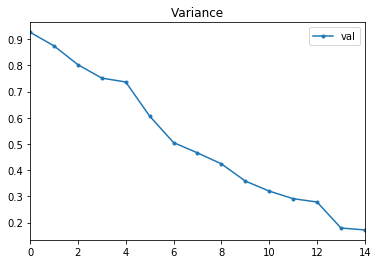

In [44]:
_ = pd.DataFrame({'val': np.diagonal(factor_cov)}).plot(style='.-',title='Variance')

The factors are uncorrelated with one another:

In [25]:
np.allclose(np.identity(15), np.corrcoef(transformed_df.T))

True

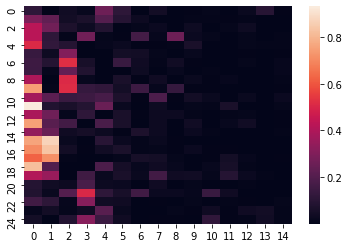

In [31]:
sns.heatmap(transformer.components_.T**2)

Note that this result is different from using factor-analyzer package

In [51]:
pd.options.display.float_format = '{:,.2f}'.format
pd.DataFrame(transformed_df).describe()
# Mean seems all close to 0
# The variance are in descending order.

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
count,"2,436.00","2,436.00","2,436.00","2,436.00","2,436.00","2,436.00","2,436.00","2,436.00","2,436.00","2,436.00","2,436.00","2,436.00","2,436.00","2,436.00","2,436.00"
mean,0.00,0.00,0.00,-0.00,0.00,0.00,0.00,0.00,-0.00,-0.00,-0.00,0.00,-0.00,-0.00,-0.00
std,0.96,0.93,0.90,0.87,0.86,0.78,0.71,0.68,0.65,0.60,0.57,0.54,0.53,0.42,0.41
min,-2.40,-2.86,-2.93,-2.93,-3.04,-3.14,-2.68,-2.40,-1.84,-2.58,-1.75,-1.99,-2.15,-1.83,-2.03
25%,-0.69,-0.62,-0.58,-0.57,-0.56,-0.50,-0.46,-0.42,-0.42,-0.37,-0.36,-0.34,-0.34,-0.27,-0.26
50%,-0.04,0.01,0.03,0.02,-0.02,-0.02,0.00,0.00,-0.03,-0.00,-0.00,0.00,-0.01,-0.02,-0.01
75%,0.65,0.59,0.59,0.55,0.55,0.46,0.45,0.43,0.41,0.38,0.34,0.35,0.33,0.25,0.26
max,3.53,4.09,4.24,3.34,3.36,3.64,2.91,2.61,2.90,2.92,2.32,2.41,2.46,1.95,2.09


# Understand the transformation

In [53]:
display(transformer.components_.T.shape)
display(len(transformer.noise_variance_))
display(transformer.noise_variance_)

(25, 15)

25

array([1.22587921, 0.38301996, 0.71897666, 0.87301515, 0.73043126,
       0.90599073, 0.64778901, 1.09729654, 0.79358028, 0.77534895,
       1.21580762, 1.02391071, 0.86960812, 0.63846827, 0.93142597,
       0.65228361, 0.58392963, 0.97573618, 1.03635827, 1.22214919,
       0.80192605, 1.01098244, 0.71198945, 0.92112306, 0.91303238])

According to the sorce code, very roughly <br>
$$ \hat{\mu} = X * \hat{W} * (I + \hat{W}.\hat{W}^T)^{-1}$$

It is likely the expected value of Mu, given the distribution of x below (sklearn documentation for factor analysis)
$$ p(x)= N(\mu, WW^T + \Psi) $$

In [37]:
"""
Source code:
https://github.com/scikit-learn/scikit-learn/blob/fd237278e/sklearn/decomposition/_factor_analysis.py#L251
Taken from Barber's Bayesian Reasoning textbook

X = check_array(X)
Ih = np.eye(len(self.components_)) # identitiy matrix

X_transformed = X - self.mean_ # de-meaen

Wpsi = self.components_ / self.noise_variance_
cov_z = linalg.inv(Ih + np.dot(Wpsi, self.components_.T))
tmp = np.dot(X_transformed, Wpsi.T)
X_transformed = np.dot(tmp, cov_z)
"""

(2436, 15)